In [1]:
import os
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import random_split
from tqdm.auto import tqdm
import torchvision
import torchvision.transforms as transforms
import albumentations as A
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
import warnings
warnings.filterwarnings('ignore')

In [2]:
train_images_path = "../input/chest-xrays-bacterial-viral-pneumonia-normal/train_images/train_images"
test_images_path = "../input/chest-xrays-bacterial-viral-pneumonia-normal/test_images/test_images"
train = pd.read_csv("../input/chest-xrays-bacterial-viral-pneumonia-normal/labels_train.csv")

In [3]:
train.head()

,file_name,class_id
0,img_4358977458434011046.jpg,1
1,img_5224016757187192130.jpg,2
2,img_3065202206106254707.jpg,2
3,img_6304894865561547174.jpg,1
4,img_3371338542810939877.jpg,2


- Class 0: no disease

- Class 1: bacterial pneumonia

- Class 2: viral pneumonia

In [4]:
batch_size = 32
img_size = 256
epochs = 10
lr = 0.0001

In [5]:
class PneumoniaDataset:
    def __init__(self, df, transform):
        self.df = df
        self.file_names = df['file_name'].values
        self.targets = df['class_id'].values
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        file_path = self.file_names[idx]
        image = Image.open(os.path.join(train_images_path, file_path))
#         image = np.array(image)
        target = self.targets[idx]
        
        if self.transform is not None:
            image = self.transform(image).float()
        
        image = image
        target = torch.tensor(target, dtype=torch.long)
            
        return {
            "image": image,
            "target": target
        }

In [6]:
transform = transforms.Compose([
                                transforms.Resize(img_size),
                                transforms.CenterCrop(224), 
                                transforms.RandomHorizontalFlip(), 
                                transforms.RandomRotation(10), 
                                transforms.RandomAffine(translate=(0.05, 0.05), degrees=0),
                                transforms.Grayscale(num_output_channels=1),
                                transforms.ToTensor()])

In [7]:
dataset = PneumoniaDataset(train, transform=transform)
print(dataset[1])

{'image': tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]]), 'target': tensor(2)}


In [8]:
train_size = round(len(dataset)*0.7)
val_size = len(dataset) - train_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(3270, 1402)

In [9]:
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size,shuffle=True, num_workers = os.cpu_count())
valid_loader = torch.utils.data.DataLoader(val_ds, batch_size=batch_size*2,shuffle=False, num_workers = os.cpu_count())

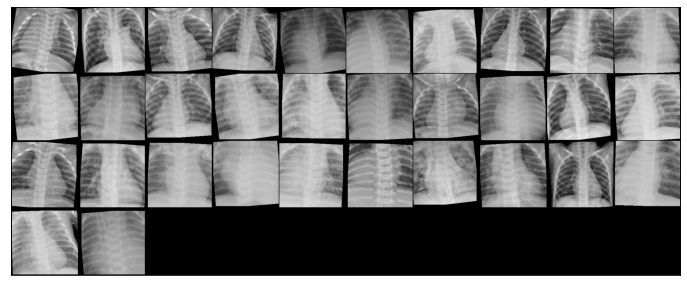

In [10]:
def show_batch(dl):
    for data in dl:
        images = data['image']
        targets = data['target']
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(torchvision.utils.make_grid(images[:60], nrow=10).permute(1,2,0))
        break

show_batch(train_loader)

In [11]:
class PneumoniaModel(nn.Module):
    def __init__(self):
        super().__init__()
        
        # pretrained model
        self.network = torchvision.models.resnet50(pretrained=True)
        self.network.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        # freeze training for all layers before classifier
        for param in self.network.fc.parameters():
            param.require_grad = False
        
        num_features = self.network.fc.in_features  # get number of features of last layer
        # -----------------------------------
        self.network.fc = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 3)
        )     # replace 1000 with 3 neurons
        
#         self.network.fc = nn.Linear(num_features, 3)  # try 
    def forward(self, x):
        return self.network(x)

In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [13]:
# testing model
model = PneumoniaModel()
output = model(train_ds[0]['image'].unsqueeze(0))
print(output)
model = model.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

tensor([[0.0296, 0.0116, 0.0228]], grad_fn=<AddmmBackward>)


In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)

In [15]:
# HELPER FUNCTIONS
def calculate_accuracy(outputs, targets):
    _, preds = torch.max(outputs, dim=1)
    accuracy = torch.tensor(torch.sum(preds == targets).item() / len(preds))
    accuracy = accuracy.detach().numpy()
    return accuracy

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def calculate_avg_auc(targets, outputs):
    # Compute ROC curve and ROC area for each class\
    softmax = nn.Softmax(dim=1)
    outputs_prob = softmax(outputs)
    
    targets = targets.detach().cpu().numpy()
    targets = label_binarize(targets, classes=[0, 1, 2])
    outputs = outputs_prob.detach().cpu().numpy()
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(3):
        fpr[i], tpr[i], _ = roc_curve(targets[:, i], outputs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(targets.ravel(), outputs.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    return fpr["micro"], tpr["micro"], roc_auc

In [16]:
def train_fn(train_loader, optimizer, criterion, epoch):
    
    # model in train mode
    model.train()
    
    # setting progress bar object
    tk0 = tqdm(train_loader, total=len(train_loader))
    
    # initiating loss and accuracy averagemeter object
    losses = AverageMeter()
    accuracies = AverageMeter()
    aucs = AverageMeter()
    tprs = AverageMeter()
    fprs = AverageMeter()
    # iterating over complete batch
    
    for batch_idx, data in enumerate(tk0):
        tk0.set_description(f"Epoch: {epoch + 1} [train]")
        images = data['image']
        targets = data['target']
        images = images.to(device)   # images to GPU
        targets = targets.to(device) # targets to GPU
        
        optimizer.zero_grad()       # zero grading the optimizer
        
        outputs = model(images)     # passing image through the model
        loss = criterion(outputs, targets) # calculating loss
        accuracy = calculate_accuracy(outputs, targets) # calculating accuracy
        loss.backward()             # performing backpropagation
        optimizer.step()            # stepping the optimizer
        
        fpr, tpr, auc = calculate_avg_auc(targets, outputs)
        
        losses.update(loss.item(), batch_size)
        accuracies.update(accuracy.item(), batch_size)
        aucs.update(auc['micro'].item(), batch_size)
        tprs.update(tpr.mean(), batch_size)
        fprs.update(fpr.mean(), batch_size)
        
        
        tk0.set_postfix({
            "loss": losses.avg,
            "accuracy": accuracies.avg,
            "auc": aucs.avg,
            "fpr": fprs.avg,
            "tpr": tprs.avg
        })
    
    return losses.avg, aucs.avg

def eval_fn(valid_loader, epoch):
        
    # model in train mode
    model.eval()
    
    # setting progress bar object
    tk0 = tqdm(valid_loader, total=len(valid_loader))
    
    # initiating loss and accuracy averagemeter object
    losses = AverageMeter()
    accuracies = AverageMeter()
    aucs = AverageMeter()
    tprs = AverageMeter()
    fprs = AverageMeter()
    
    # iterating over complete batch
    for batch_idx, data in enumerate(tk0):
        tk0.set_description(f"Epoch: {epoch + 1} [eval]")
        images = data['image']
        targets = data['target']
        images = images.to(device)   # images to GPU
        targets = targets.to(device) # targets to GPU
                
        outputs = model(images)     # passing image through the model
        loss = criterion(outputs, targets) # calculating loss
        accuracy = calculate_accuracy(outputs, targets) # calculating accuracy
        
        fpr, tpr, auc = calculate_avg_auc(targets, outputs)

        losses.update(loss.item(), batch_size)
        accuracies.update(accuracy.item(), batch_size)
        aucs.update(auc['micro'].item(), batch_size)
        tprs.update(tpr.mean(), batch_size)
        fprs.update(fpr.mean(), batch_size)
        
        tk0.set_postfix({
            "loss": losses.avg,
            "accuracy": accuracies.avg,
            "auc": aucs.avg,
            "fpr": fprs.avg,
            "tpr": tprs.avg
        })
    
    return losses.avg, aucs.avg

In [17]:
best_auc = 0

for epoch in range(epochs):
    train_loss, train_auc = train_fn(train_loader, optimizer, criterion, epoch)
    val_loss, val_auc = eval_fn(valid_loader, epoch)
    

    if val_auc > best_auc:
        tqdm.write(f"ROC-AUC increased from {best_auc:.4f} -> {val_auc:.4f}, saving model")
        best_auc = val_auc
        torch.save(model.state_dict(), "resnet50_model.pth")

  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

ROC-AUC increased from 0.0000 -> 0.8939, saving model


  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

ROC-AUC increased from 0.8939 -> 0.9084, saving model


  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

ROC-AUC increased from 0.9084 -> 0.9132, saving model


  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

ROC-AUC increased from 0.9132 -> 0.9169, saving model


  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

ROC-AUC increased from 0.9169 -> 0.9292, saving model


  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

ROC-AUC increased from 0.9292 -> 0.9375, saving model


  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

ROC-AUC increased from 0.9375 -> 0.9403, saving model


  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

In [18]:
def predict(index):
    
    model.load_state_dict(torch.load("./resnet50_model.pth"))
    model.eval()
    output = model(val_ds[index]['image'].unsqueeze(0).to(device))
    expected = val_ds[index]['target']
    fin_output = torch.argmax(output)
    print(f"Model output: {fin_output}")
    print(f"Expected :    {expected}")

In [19]:
# predicting from test set
for i in range(50):
    predict(i)
    print("-"*20)

Model output: 0
Expected :    0
--------------------
Model output: 1
Expected :    2
--------------------
Model output: 0
Expected :    0
--------------------
Model output: 2
Expected :    2
--------------------
Model output: 1
Expected :    2
--------------------
Model output: 2
Expected :    2
--------------------
Model output: 2
Expected :    0
--------------------
Model output: 0
Expected :    0
--------------------
Model output: 0
Expected :    0
--------------------
Model output: 2
Expected :    1
--------------------
Model output: 2
Expected :    2
--------------------
Model output: 0
Expected :    0
--------------------
Model output: 1
Expected :    1
--------------------
Model output: 1
Expected :    2
--------------------
Model output: 1
Expected :    1
--------------------
Model output: 0
Expected :    0
--------------------
Model output: 2
Expected :    1
--------------------
Model output: 1
Expected :    1
--------------------
Model output: 0
Expected :    0
--------------